In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt
A_to_au_conversion = 1.8897259885789
# A_to_au_conversion = 1

In [8]:
def calc_vqe_LiH(r):
    symbols = ["Li", "H"]
    geometry = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r*A_to_au_conversion])
    H, qubits = qchem.molecular_hamiltonian(
        symbols,
        geometry,
        active_electrons=2,
        active_orbitals=4
    )
    
    print("Number of qubits = ", qubits)
    print("The Hamiltonian is ", H)
    
    dev = qml.device("lightning.qubit", wires=qubits)
    electrons = 2
    hf = qml.qchem.hf_state(electrons, qubits)

    def circuit(param, wires):
        qml.BasisState(hf, wires=wires)
        qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

    @qml.qnode(dev, interface="autograd")
    def cost_fn(param):
        circuit(param, wires=range(qubits))
        return qml.expval(H)

    opt = qml.GradientDescentOptimizer(stepsize=0.4)
    theta = np.array(0.0, requires_grad=True)

    # store the values of the cost function
    energy = [cost_fn(theta)]
    # store the values of the circuit parameter
    angle = [theta]
    max_iterations = 100
    conv_tol = 1e-06

    for n in range(max_iterations):
        theta, prev_energy = opt.step_and_cost(cost_fn, theta)

        energy.append(cost_fn(theta))
        angle.append(theta)

        conv = np.abs(energy[-1] - prev_energy)

        if n % 2 == 0:
            print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

        if conv <= conv_tol:
            break

    return energy, angle, n


def plot_optimization(energy, angle, n, E_fci):
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(12)

    # Add energy plot on column 1
    ax1 = fig.add_subplot(121)
    ax1.plot(range(n + 2), energy, "go", ls="dashed")
    ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
    ax1.set_xlabel("Optimization step", fontsize=13)
    ax1.set_ylabel("Energy (Hartree)", fontsize=13)
    # ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
    # ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add angle plot on column 2
    ax2 = fig.add_subplot(122)
    ax2.plot(range(n + 2), angle, "go", ls="dashed")
    ax2.set_xlabel("Optimization step", fontsize=13)
    ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.subplots_adjust(wspace=0.3, bottom=0.2)
    plt.show()


In [5]:
dataset_LiH = qml.data.load("qchem", molname="LiH")
E_fci = dataset_LiH[0].fci_energy
E_fci

-7.882680014448228

In [6]:
dataset_LiH[0]

<Dataset = molname: LiH, basis: STO-3G, bondlength: 1.57, attributes: ['basis', 'basis_rot_groupings', ...]>

In [9]:
energy, angle, n = calc_vqe_LiH(1.58)

Number of qubits =  8
The Hamiltonian is    (-6.7490410291132426) [I0]
+ (-0.29658878882944334) [Z7]
+ (-0.2965887888294433) [Z6]
+ (-0.29658878882933215) [Z4]
+ (-0.29658878882933215) [Z5]
+ (-0.27624029439967346) [Z2]
+ (-0.27624029439967346) [Z3]
+ (-0.10261144690401308) [Z1]
+ (-0.10261144690401296) [Z0]
+ (-0.0018050644062793423) [Y1 Y3]
+ (-0.0018050644062793423) [X1 X3]
+ (0.012060647612263501) [Y0 Y2]
+ (0.012060647612263501) [X0 X2]
+ (0.052830155628759576) [Z0 Z2]
+ (0.052830155628759576) [Z1 Z3]
+ (0.05604674414193616) [Z0 Z3]
+ (0.05604674414193616) [Z1 Z2]
+ (0.06018967503970422) [Z2 Z4]
+ (0.06018967503970422) [Z3 Z5]
+ (0.060189675039732125) [Z2 Z6]
+ (0.060189675039732125) [Z3 Z7]
+ (0.06190659624870143) [Z0 Z4]
+ (0.06190659624870143) [Z1 Z5]
+ (0.06190659624873011) [Z0 Z6]
+ (0.06190659624873011) [Z1 Z7]
+ (0.06558451169149096) [Z4 Z6]
+ (0.06558451169149096) [Z5 Z7]
+ (0.06778983998651264) [Z0 Z5]
+ (0.06778983998651264) [Z1 Z4]
+ (0.06778983998654406) [Z0 Z7]
+ (0.0

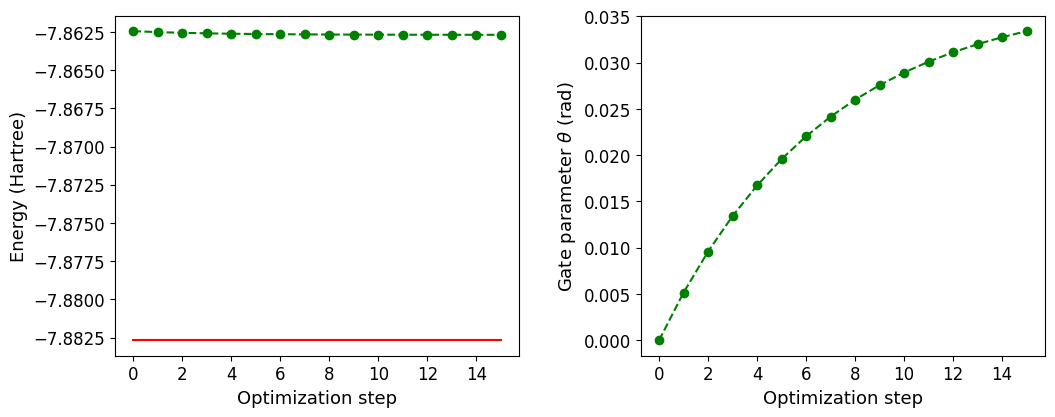

In [20]:
plot_optimization(energy, angle, n, E_fci)

In [21]:
r_array = np.arange(0.5, 5.0, 0.25)
r_array

tensor([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
        3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75], requires_grad=True)

In [22]:
E_R = []
Data = []
for i in range(len(r_array)):
    E, angle, n = calc_vqe_LiH(r_array[i])
    Data.append(E)
    E_R.append(E[-1])

Number of qubits =  10
The Hamiltonian is    (-4.8991157014818745) [I0]
+ (-0.7208556105776616) [Z8]
+ (-0.7208556105776613) [Z9]
+ (-0.4027880539816294) [Z6]
+ (-0.40278805398162937) [Z7]
+ (-0.4027880539814696) [Z4]
+ (-0.4027880539814695) [Z5]
+ (-0.36829626924330283) [Z3]
+ (-0.3682962692433028) [Z2]
+ (-0.3593182257565537) [Z1]
+ (-0.35931822575655364) [Z0]
+ (-0.009981242961012798) [Y0 Y2]
+ (-0.009981242961012798) [X0 X2]
+ (-0.0007905626964898289) [Y1 Y3]
+ (-0.0007905626964898289) [X1 X3]
+ (0.06132595616857582) [Z0 Z2]
+ (0.06132595616857582) [Z1 Z3]
+ (0.06143399453545146) [Z2 Z4]
+ (0.06143399453545146) [Z3 Z5]
+ (0.06143399453547986) [Z2 Z6]
+ (0.06143399453547986) [Z3 Z7]
+ (0.06349216823226826) [Z2 Z8]
+ (0.06349216823226826) [Z3 Z9]
+ (0.0648101253991275) [Z0 Z3]
+ (0.0648101253991275) [Z1 Z2]
+ (0.06558451169149096) [Z4 Z6]
+ (0.06558451169149096) [Z5 Z7]
+ (0.06623665391506318) [Z0 Z4]
+ (0.06623665391506318) [Z1 Z5]
+ (0.06623665391509377) [Z0 Z6]
+ (0.06623665391509

/home/azhar04/anaconda3/envs/quantum-dev/lib/python3.8/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:822: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


Step = 0,  Energy = -7.02848498 Ha
Step = 2,  Energy = -7.02860633 Ha
Step = 4,  Energy = -7.02869746 Ha
Step = 6,  Energy = -7.02876589 Ha
Step = 8,  Energy = -7.02881726 Ha
Step = 10,  Energy = -7.02885583 Ha
Step = 12,  Energy = -7.02888478 Ha
Step = 14,  Energy = -7.02890651 Ha
Step = 16,  Energy = -7.02892282 Ha
Step = 18,  Energy = -7.02893506 Ha
Step = 20,  Energy = -7.02894425 Ha
Step = 22,  Energy = -7.02895114 Ha
Step = 24,  Energy = -7.02895632 Ha
Step = 26,  Energy = -7.02896020 Ha
Step = 28,  Energy = -7.02896312 Ha
Step = 30,  Energy = -7.02896530 Ha
Number of qubits =  10
The Hamiltonian is    (-5.48141622306203) [I0]
+ (-0.6059882591985428) [Z9]
+ (-0.6059882591985426) [Z8]
+ (-0.40672521313795823) [Z6]
+ (-0.4067252131379582) [Z7]
+ (-0.4067252131377964) [Z5]
+ (-0.4067252131377963) [Z4]
+ (-0.3700284727186519) [Z3]
+ (-0.37002847271865186) [Z2]
+ (-0.3391211702936707) [Z0]
+ (-0.3391211702936707) [Z1]
+ (-0.008106719225938286) [Y0 Y2]
+ (-0.008106719225938286) [X0 X2]

In [23]:
standard_vqe_data = np.column_stack((r_array, E_R))
file_name = 'standard_vqe_data.txt'
np.savetxt(file_name, standard_vqe_data, delimiter=',', header='r_array, E_R', comments='')

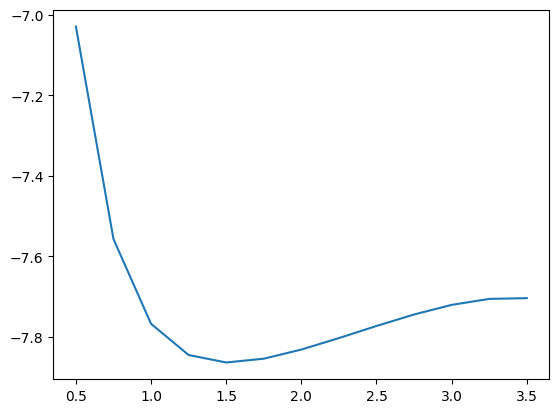

In [31]:
plt.plot(r_array[:13], E_R[:13])